In [30]:
import copy
import os
from pathlib import Path
from itertools import combinations
from scipy import stats

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scanpy as sc
from torch.utils.data import TensorDataset, DataLoader , WeightedRandomSampler

from sklearn.metrics import roc_auc_score , pairwise_distances
import torch
import torch.optim as optim
epoch_num=50
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
import scipy.sparse as sp
from numba import jit
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader , WeightedRandomSampler
import torch.optim as optim



In [31]:
import matplotlib as mpl
sns.set_theme()
# plt.rcParams.update(plt.rcParamsDefault)

plt.rcParams.update({'font.size': 18,
                     'xtick.labelsize' : 18,
                     'ytick.labelsize' : 18})

mpl.rcParams['figure.facecolor'] = 'white'
mpl.rcParams['axes.facecolor'] = 'white'

plt.rcParams.update(plt.rcParamsDefault)

# plt.rcParams['lines.linewidth'] = 6  # Line thickness

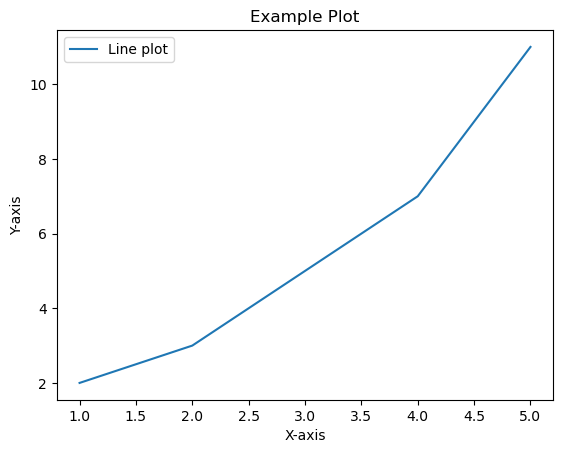

In [32]:
x = [1, 2, 3, 4, 5]
y = [2, 3, 5, 7, 11]

plt.plot(x, y, label='Line plot')
plt.xlabel('X-axis')
plt.ylabel('Y-axis')
plt.title('Example Plot')
plt.legend()
plt.savefig('example_plot.png')
plt.show()

In [33]:
device


device(type='cuda', index=0)

In [34]:
import random
import pandas as pd

def modify_labels(orig_labeles, probability=0.1):
    # Get the list of all possible labels
    all_labels = list(set(orig_labeles))

    # Create a list to store the modified labels
    modified_labels = []

    # Loop over the labels in the dataset
    for label in orig_labeles:
        # Generate a random number between 0 and 1
        r = random.random()

        # If the random number is smaller than the probability,
        # modify the label by choosing a random label from the list of all labels,
        # excluding the original label
        if r < probability:
            modified_label = random.choice([l for l in all_labels if l != label])
        else:
            modified_label = label

        # Add the modified label to the list
        modified_labels.append(modified_label)

    # Create a DataFrame with the original and modified labels
    df = pd.DataFrame({"label": orig_labeles, "modified_label": modified_labels})


    return df , (np.where(df["label"] != df["modified_label"]))

def one_hot_encode(labels):
    """
    One-hot encodes an array of labels.

    Args:
        labels (numpy.ndarray): Array of labels.

    Returns:
        tuple: One-hot encoded array of labels, and a label encoder.
    """
    values = np.array(labels)
    print(values)
    # integer encode
    label_encoder = LabelEncoder()
    integer_encoded = label_encoder.fit_transform(values)
    print(integer_encoded)
    # binary encode
    onehot_encoder = OneHotEncoder(sparse_output=False)
    integer_encoded = integer_encoded.reshape(len(integer_encoded), 1)
    onehot_encoded = onehot_encoder.fit_transform(integer_encoded)
    # invert first example
    inverted = label_encoder.inverse_transform([np.argmax(onehot_encoded[0, :])])
    return onehot_encoded, label_encoder

def create_intermediate_state(adata,key,labels):
    bdata = adata.copy()
    # change_weight= np.random.normal(0,0.5,adata.n_obs)
    # change_weight  =np.clip(change_weight, a_max=0.5, a_min=0)
    half_size = adata.n_obs // 2
    zeros = np.zeros(half_size)
    uniform_values = np.random.uniform(0.0, 1, adata.n_obs - half_size)
    samples = np.concatenate((zeros, uniform_values))
    np.random.shuffle(samples)
    change_weight = samples
    for i in range(adata.n_obs):
        if adata.obs[key].iloc[i] in labels:
            for label in labels:
                if label != adata.obs[key].iloc[i]:
                    adata_tmp= adata[adata.obs[key].isin([label])]
                    bdata[i].X = (1-change_weight[i])*adata[i].X + change_weight[i]* adata_tmp[np.random.randint(adata_tmp.n_obs)].X
        else:
            change_weight[i]=0
    bdata.obs['change_weight']+=change_weight
    return bdata

In [35]:
class Net(nn.Module):
    def __init__(self, input_size, output_size,activation='relu',hidden_layers=2):
        """
        Initializes a feedforward neural network with three fully-connected layers.

        Args:
            input_size (int): Size of the input layer.
            output_size (int): Size of the output layer.
        """
        super(Net, self).__init__()
        self.fc1 = nn.Linear(input_size, int(input_size / 2))
        self.fc2 = nn.Linear(int(input_size / 2), int(input_size / 4))
        self.fc3 = nn.Linear(int(input_size / 4), int(input_size / 4))
        self.fc4 = nn.Linear(int(input_size / 4), int(input_size / 4))
        self.fc5 = nn.Linear(int(input_size / 4), output_size)
        if activation == 'relu':
            self.activation = F.relu
        elif activation == 'tanh':
            self.activation = F.tanh
        elif activation == 'sigmoid':
            self.activation = F.sigmoid
        self.hidden_layers = hidden_layers

    def forward(self, x):
        """
        Performs the forward pass of the neural network.

        Args:
            x (torch.Tensor): Input data of shape (batch_size, input_size).

        Returns:
            torch.Tensor: Output data of shape (batch_size, output_size).
        """
        if self.hidden_layers == 2:
            x = self.fc1(x)
            x = self.activation(x)
            x = self.fc2(x)
            x = self.activation(x)
            x = self.fc5(x)
        elif self.hidden_layers == 3:
            x = self.fc1(x)
            x = self.activation(x)
            x = self.fc2(x)
            x = self.activation(x)
            x = self.fc3(x)
            x = self.activation(x)
            x = self.fc5(x)
        elif self.hidden_layers == 4:
            x = self.fc1(x)
            x = self.activation(x)
            x = self.fc2(x)
            x = self.activation(x)
            x = self.fc3(x)
            x = self.activation(x)
            x = self.fc4(x)
            x = self.activation(x)
            x = self.fc5(x)
        output = F.log_softmax(x, dim=-1)
        return output


In [36]:
n=1000
p=50000
adata = sc.datasets.blobs(n_variables=n,n_centers=4,cluster_std=1,n_observations=p)
adata.obs['change_weight']= np.zeros(adata.n_obs)
sc.pp.pca(adata)
sc.pp.neighbors(adata)
sc.tl.umap(adata)
adata

AnnData object with n_obs × n_vars = 50000 × 1000
    obs: 'blobs', 'change_weight'
    uns: 'pca', 'neighbors', 'umap'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    obsp: 'distances', 'connectivities'

In [37]:
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
labeles = adata.obs['blobs']
df , were_changed = modify_labels(labeles , probability=0.00)
df

,label,modified_label
0,0,0
1,0,0
2,0,0
3,0,0
4,0,0
...,...,...
49995,3,3
49996,2,2
49997,0,0
49998,1,1


In [38]:
y_train = adata.obs['blobs']
y_train_indices = y_train.unique()
class_sample_count = np.array(
    [sum(y_train == t) for t in y_train_indices])
weight = 1. / class_sample_count
samples_weight= np.zeros(adata.n_obs)
for i in range(adata.n_obs):
    for j, t in enumerate(y_train_indices):
        if adata.obs['blobs'].iloc[i]==t:
            samples_weight[i]=weight[j]
samples_weight = torch.from_numpy(samples_weight)
# samples_weight

In [39]:
one_hot_label , inverted_label = one_hot_encode(df['label'])
import time

['0' '0' '0' ... '0' '1' '2']
[0 0 0 ... 0 1 2]


In [40]:
def probability_for_confidence(y_pred, y_true):
    """
    Calculates the probability that the predicted class is correct, given the predicted class probabilities and the true class labels.

    Args:
        y_pred (torch.Tensor): Tensor of shape (batch_size, num_classes) with predicted class probabilities.
        y_true (torch.Tensor): Tensor of shape (batch_size, num_classes) with true class labels.

    Returns:
        torch.Tensor: Tensor of shape (batch_size,) with the probability that the predicted class is correct for each sample.
    """
    prob = torch.exp(y_pred)
    return torch.sum(prob * y_true, axis=1)
import gc
def probability_list_to_confidence_and_var(prob_list, n_obs, epoch_num):
    """
    Calculates the confidence and variability of the predicted class probabilities, given a list of predicted class probabilities.

    Args:
        prob_list (list): List of tensors of shape (batch_size,) with predicted class probabilities.
        n_obs (int): Number of observations.
        epoch_num (int): Number of epochs.

    Returns:
        tuple: Tensor of shape (batch_size,) with the confidence of the predicted class probabilities, and a tensor of shape (batch_size,) with the variability of the predicted class probabilities.
    """
    confidence = torch.zeros(n_obs)
    for i in range(epoch_num):
        confidence += (prob_list[i])
    confidence = confidence / epoch_num
    variability = torch.zeros(n_obs)
    for i in range(epoch_num):
        variability += torch.square(confidence - (prob_list[i]))
    variability = variability / epoch_num
    variability = torch.sqrt(variability)
    return confidence, variability


In [41]:
def train_and_measure_cor_with_change(activation='relu',epoch_num=75,lr=0.001,batch_size=128,hiden_layers=2,genes=1000,cells=5000):
    n=genes
    p=cells
    adata = sc.datasets.blobs(n_variables=n,n_centers=4,cluster_std=1,n_observations=p)
    adata.obs['change_weight']= np.zeros(adata.n_obs)
    sc.pp.pca(adata)
    sc.pp.neighbors(adata)
    adata = create_intermediate_state(adata,'blobs',['0','1'])
    adata = create_intermediate_state(adata,'blobs',['2','3'])
    sc.pp.pca(adata)
    sc.pp.neighbors(adata)
    sc.tl.umap(adata)
    labeles = adata.obs['blobs']
    df , were_changed = modify_labels(labeles , probability=0.00)
    y_train = adata.obs['blobs']
    y_train_indices = y_train.unique()
    class_sample_count = np.array(
        [sum(y_train == t) for t in y_train_indices])
    weight = 1. / class_sample_count
    samples_weight= np.zeros(adata.n_obs)
    for i in range(adata.n_obs):
        for j, t in enumerate(y_train_indices):
            if adata.obs['blobs'].iloc[i]==t:
                samples_weight[i]=weight[j]
    samples_weight = torch.from_numpy(samples_weight)



    t = time.time()

    one_hot_label , inverted_label = one_hot_encode(df['label'])
    net = Net(adata.X.shape[1],output_size=4,activation=activation,hidden_layers=hiden_layers)
    net.to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.SGD(net.parameters(), lr=lr, momentum=0.9)
    x_data = np.array(adata.X)
    sampler = WeightedRandomSampler(samples_weight.type('torch.DoubleTensor'), len(samples_weight))
    tensor_x = torch.Tensor(x_data).to(device) # transform to torch tensor
    # tensor_y_noisy = torch.Tensor(one_hot_modified_label).to(device)
    tensor_y_true = torch.Tensor(one_hot_label).to(device)
    my_dataset = TensorDataset(tensor_x,tensor_y_true) # create your datset

    trainloader = torch.utils.data.DataLoader(my_dataset, batch_size=batch_size,
                                              sampler=sampler, num_workers=0)

    prob_loss_list = []
    for epoch in range(epoch_num):  # loop over the dataset multiple times
        prob_all=[]

        outputs_all = net(tensor_x)
        tensor_y_true_temp = torch.Tensor(one_hot_label).to(device)
        prob_all = probability_for_confidence(outputs_all, tensor_y_true)

        prob_loss_list.append(prob_all.cpu().detach().numpy())

        running_loss = 0.0
        for i, data in enumerate(trainloader, 0):
            # get the inputs; data is a list of [inputs, labels]
            inputs, labels = data
            inputs = inputs.to(device)
            labels = labels.to(device)
            # inputs, labels = inputs.cuda(), labels.cuda()

            # zero the parameter gradients
            optimizer.zero_grad()

            # forward + backward + optimize
            outputs = net(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            # print statistics
            running_loss += loss.item()

            if i % 10 == 1:    # print every 2000 mini-batches
                print(f'[{epoch + 1}, {i + 1:5d}] loss: {running_loss / 10:.3f}')
                running_loss = 0.0
            del inputs, labels, outputs, loss
            # gc.collect()
            # torch.cuda.empty_cache()



    print('Finished Training')



    all_conf , all_var = probability_list_to_confidence_and_var(prob_loss_list, n_obs= adata.n_obs, epoch_num=epoch_num)
    adata.obs["conf"] = all_conf.detach().numpy()
    # if adata_conf_ref is not None:
    #     print("ws")
    #     res = stats.wasserstein_distance(adata.obs['conf'], adata_conf_ref)
    #     print(res,"wasserstein_distance")
    # else:
    #     res = stats.spearmanr(adata.obs['conf'], adata.obs['change_weight'])
    #     print(res,"spearmanr correlation")
    time_elapsed = time.time() - t
    print('time:', time.time()-t)
    memory = torch.cuda.memory_allocated()
    # #convert to gb
    memory_allocated_gb = memory / (1024 ** 3)
    print("gpu memory:", memory_allocated_gb)
        # Cleanup to free GPU memory
    del net, tensor_x, tensor_y_true, my_dataset, trainloader
    # del net
    # torch.cuda.empty_cache()
    gc.collect()
    torch.cuda.empty_cache()

    print("gpu memory:", torch.cuda.memory_allocated()/ (1024 ** 3))
    return all_conf.detach().numpy(), all_var,time.time()-t,memory_allocated_gb
train_and_measure_cor_with_change(genes=1000,cells=50000)


['0' '0' '0' ... '0' '1' '2']
[0 0 0 ... 0 1 2]
[1,     2] loss: 0.250
[1,    12] loss: 0.681
[1,    22] loss: 0.516
[1,    32] loss: 0.458
[1,    42] loss: 0.448
[1,    52] loss: 0.447
[1,    62] loss: 0.461
[1,    72] loss: 0.473
[1,    82] loss: 0.471
[1,    92] loss: 0.444
[1,   102] loss: 0.436
[1,   112] loss: 0.434
[1,   122] loss: 0.439
[1,   132] loss: 0.448
[1,   142] loss: 0.465
[1,   152] loss: 0.459
[1,   162] loss: 0.453
[1,   172] loss: 0.461
[1,   182] loss: 0.450
[1,   192] loss: 0.427
[1,   202] loss: 0.414
[1,   212] loss: 0.438
[1,   222] loss: 0.443
[1,   232] loss: 0.454
[1,   242] loss: 0.454
[1,   252] loss: 0.439
[1,   262] loss: 0.443
[1,   272] loss: 0.417
[1,   282] loss: 0.435
[1,   292] loss: 0.414
[1,   302] loss: 0.419
[1,   312] loss: 0.443
[1,   322] loss: 0.421
[1,   332] loss: 0.410
[1,   342] loss: 0.460
[1,   352] loss: 0.445
[1,   362] loss: 0.423
[1,   372] loss: 0.419
[1,   382] loss: 0.430
[2,     2] loss: 0.086
[2,    12] loss: 0.439
[2,    22

(array([0.97754514, 0.98064893, 0.52000976, ..., 0.50331306, 0.97287995,
        0.98204786], dtype=float32),
 tensor([0.0932, 0.0918, 0.0659,  ..., 0.0637, 0.0780, 0.0682]),
 33.02954339981079,
 0.3375244140625)

In [42]:
print(torch.cuda.memory_allocated())
torch.cuda.memory_allocated()

0


0

In [43]:
torch.cuda.memory_allocated()


0

In [44]:
#ALSO ADDED THE NUMBET OF GENENS NOT CELL FROM 1000 TO 10000

In [ ]:
cell_num = [1000,5000,10000,20000,30000,40000,50000,60000,70000,80000,90000,100000]
cell_num_mesured = []
time_list = []
memory_list = []
for i in cell_num:
    print("cell number",i)
    print(torch.cuda.memory_allocated())
    _,_,time_elapsed,memory = train_and_measure_cor_with_change(cells=i)
    time_list.append(time_elapsed)
    memory_list.append(memory)
gene_num = [1000,5000,10000,20000,30000,40000]
time_list_gene = []
memory_list_gene = []
for i in gene_num:
    print(i)
    _,_,time_elapsed,memory = train_and_measure_cor_with_change(genes=i)
    time_list_gene.append(time_elapsed)
    memory_list_gene.append(memory)


cell number 1000
0
['0' '3' '0' '1' '3' '3' '1' '3' '1' '1' '3' '0' '1' '2' '0' '0' '3' '2'
 '2' '1' '3' '2' '3' '1' '2' '0' '2' '1' '1' '0' '1' '0' '0' '0' '2' '1'
 '3' '1' '3' '1' '1' '1' '0' '0' '0' '0' '2' '2' '0' '1' '3' '1' '3' '2'
 '3' '0' '0' '1' '2' '3' '3' '0' '0' '3' '3' '1' '2' '1' '3' '0' '1' '0'
 '2' '3' '3' '3' '1' '2' '2' '3' '2' '0' '1' '3' '0' '3' '3' '1' '3' '1'
 '2' '3' '0' '0' '2' '2' '1' '3' '1' '0' '0' '2' '0' '0' '1' '2' '3' '3'
 '2' '2' '3' '1' '3' '2' '1' '1' '1' '0' '3' '1' '1' '1' '0' '0' '2' '1'
 '1' '0' '0' '3' '1' '3' '0' '3' '0' '2' '0' '2' '0' '3' '1' '3' '0' '1'
 '1' '1' '1' '0' '0' '2' '0' '2' '0' '0' '2' '1' '2' '3' '0' '1' '0' '3'
 '0' '3' '0' '3' '1' '2' '3' '2' '1' '3' '0' '2' '3' '0' '0' '2' '3' '0'
 '0' '0' '0' '3' '1' '0' '1' '0' '3' '1' '3' '1' '2' '3' '3' '1' '2' '2'
 '2' '2' '1' '2' '1' '1' '3' '3' '0' '1' '0' '1' '2' '2' '2' '2' '3' '1'
 '0' '2' '3' '3' '0' '1' '2' '3' '3' '3' '2' '0' '3' '3' '2' '2' '3' '2'
 '2' '3' '3' '0' '2' '1' '3' '3'

In [ ]:
plt.rcParams.update({'font.size': 18,
                     'xtick.labelsize' : 18,
                     'ytick.labelsize' : 18})

plt.plot(cell_num[0:len(time_list)],time_list,marker='o')
plt.xlabel('Number of cells')
plt.ylabel('Time')
plt.title('Time vs Number of cells')
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.ylim(0, max(time_list)+10)
plt.savefig('figures/time_vs_cells_1.png',dpi=600)
print("time_list",time_list)
plt.show()

plt.plot(gene_num[0:len(time_list_gene)],time_list_gene,marker='o')
plt.xlabel('Number of genes')
plt.ylabel('Time')
plt.title('Time vs Number of cells')
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.ylim(0, max(time_list_gene)+40)
plt.savefig('figures/time_vs_genes_2.png',dpi=600)
print("time_list_gene",time_list_gene)
plt.show()

plt.plot(cell_num,memory_list,marker='o')
plt.xlabel('Number of cells')
plt.ylabel('Memory')
plt.title('Memory vs Number of cells')
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.ylim(0, max(memory_list)+0.2)
plt.savefig('figures/memory_vs_cells_3.png',dpi=600)
print("memory_list",memory_list)
plt.show()

plt.plot(gene_num[0:len(memory_list_gene)],memory_list_gene,marker='o')
plt.xlabel('Number of genes')
plt.ylabel('Memory')
plt.title('Memory vs Number of genes')
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.ylim(0, max(memory_list_gene)+2)
plt.savefig('figures/memory_vs_genes_4.png',dpi=600)
print("memory_list_gene",memory_list_gene)
plt.show()

In [ ]:

# Check if CUDA is available
if torch.cuda.is_available():
    # Get the current device index
    current_device = torch.cuda.current_device()

    # Get the name of the current device
    device_name = torch.cuda.get_device_name(current_device)

    print(f"Current GPU device index: {current_device}")
    print(f"Current GPU device name: {device_name}")
else:
    print("CUDA is not available. Running on CPU.")
import torch

# Check if CUDA is available
if torch.cuda.is_available():
    # Get the current device index
    current_device = torch.cuda.current_device()

    # Get the name of the current device
    device_name = torch.cuda.get_device_name(current_device)

    print(f"Current GPU device index: {current_device}")
    print(f"Current GPU device name: {device_name}")
else:
    print("CUDA is not available. Running on CPU.")


In [ ]:
cell_num[0:len(time_list)]

In [ ]:
import scanpy as sc

# Load a sample dataset
adata = sc.datasets.pbmc3k()

# Preprocessing: Filtering, normalization, and log transformation
sc.pp.filter_cells(adata, min_genes=200)
sc.pp.filter_genes(adata, min_cells=3)
adata.var['mt'] = adata.var_names.str.startswith('MT-')
sc.pp.calculate_qc_metrics(adata, qc_vars=['mt'], percent_top=None, log1p=False, inplace=True)
adata = adata[adata.obs.n_genes_by_counts < 2500, :]
adata = adata[adata.obs.pct_counts_mt < 5, :]
sc.pp.normalize_total(adata, target_sum=1e4)
sc.pp.log1p(adata)

# Highly variable genes and scaling
sc.pp.highly_variable_genes(adata, min_mean=0.0125, max_mean=3, min_disp=0.5)
adata = adata[:, adata.var.highly_variable]
sc.pp.scale(adata, max_value=10)

# PCA
sc.tl.pca(adata, svd_solver='arpack')

# Compute the neighborhood graph
sc.pp.neighbors(adata, n_neighbors=10, n_pcs=40)

# Clustering using Leiden and Louvain methods
sc.tl.leiden(adata)
sc.tl.louvain(adata)

# Run PAGA
sc.tl.paga(adata, groups='leiden')

# Plot PAGA graph
sc.pl.paga(adata, plot=True)

# Compute and plot UMAP with PAGA initialization
sc.tl.umap(adata, init_pos='paga')
sc.pl.umap(adata, color=['leiden', 'louvain', 'CST3', 'NKG7'])
